Nombre de features utilisées: 21
Features: ['Diff_Temps_Minutes', 'Temp échappement Droit 540', 'Temp échappement Droit 540_Panne', 'RUL_minute', 'RUL_heure']...

=== Test avec MinMaxScaler ===
Fenêtre: 20
  Architecture: CNN
    Erreur avec CNN: Exception encountered when calling Conv1D.call().

Negative dimension size caused by subtracting 3 from 2 for '{{node sequential_1/conv1d_4_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_1/conv1d_4_1/convolution/ExpandDims, sequential_1/conv1d_4_1/convolution/ExpandDims_1)' with input shapes: [?,1,2,128], [1,3,128,256].

Arguments received by Conv1D.call():
  • inputs=tf.Tensor(shape=(None, 2, 128), dtype=float32)
  Architecture: CNN-LSTM Sequential
    RMSE: 0.5758, MAE: 0.4141, R²: 0.9333, Params: 229441
  Architecture: CNN-LSTM Parallel
    Erreur avec CNN-LSTM Parallel: Only input tensors may be passed as positio

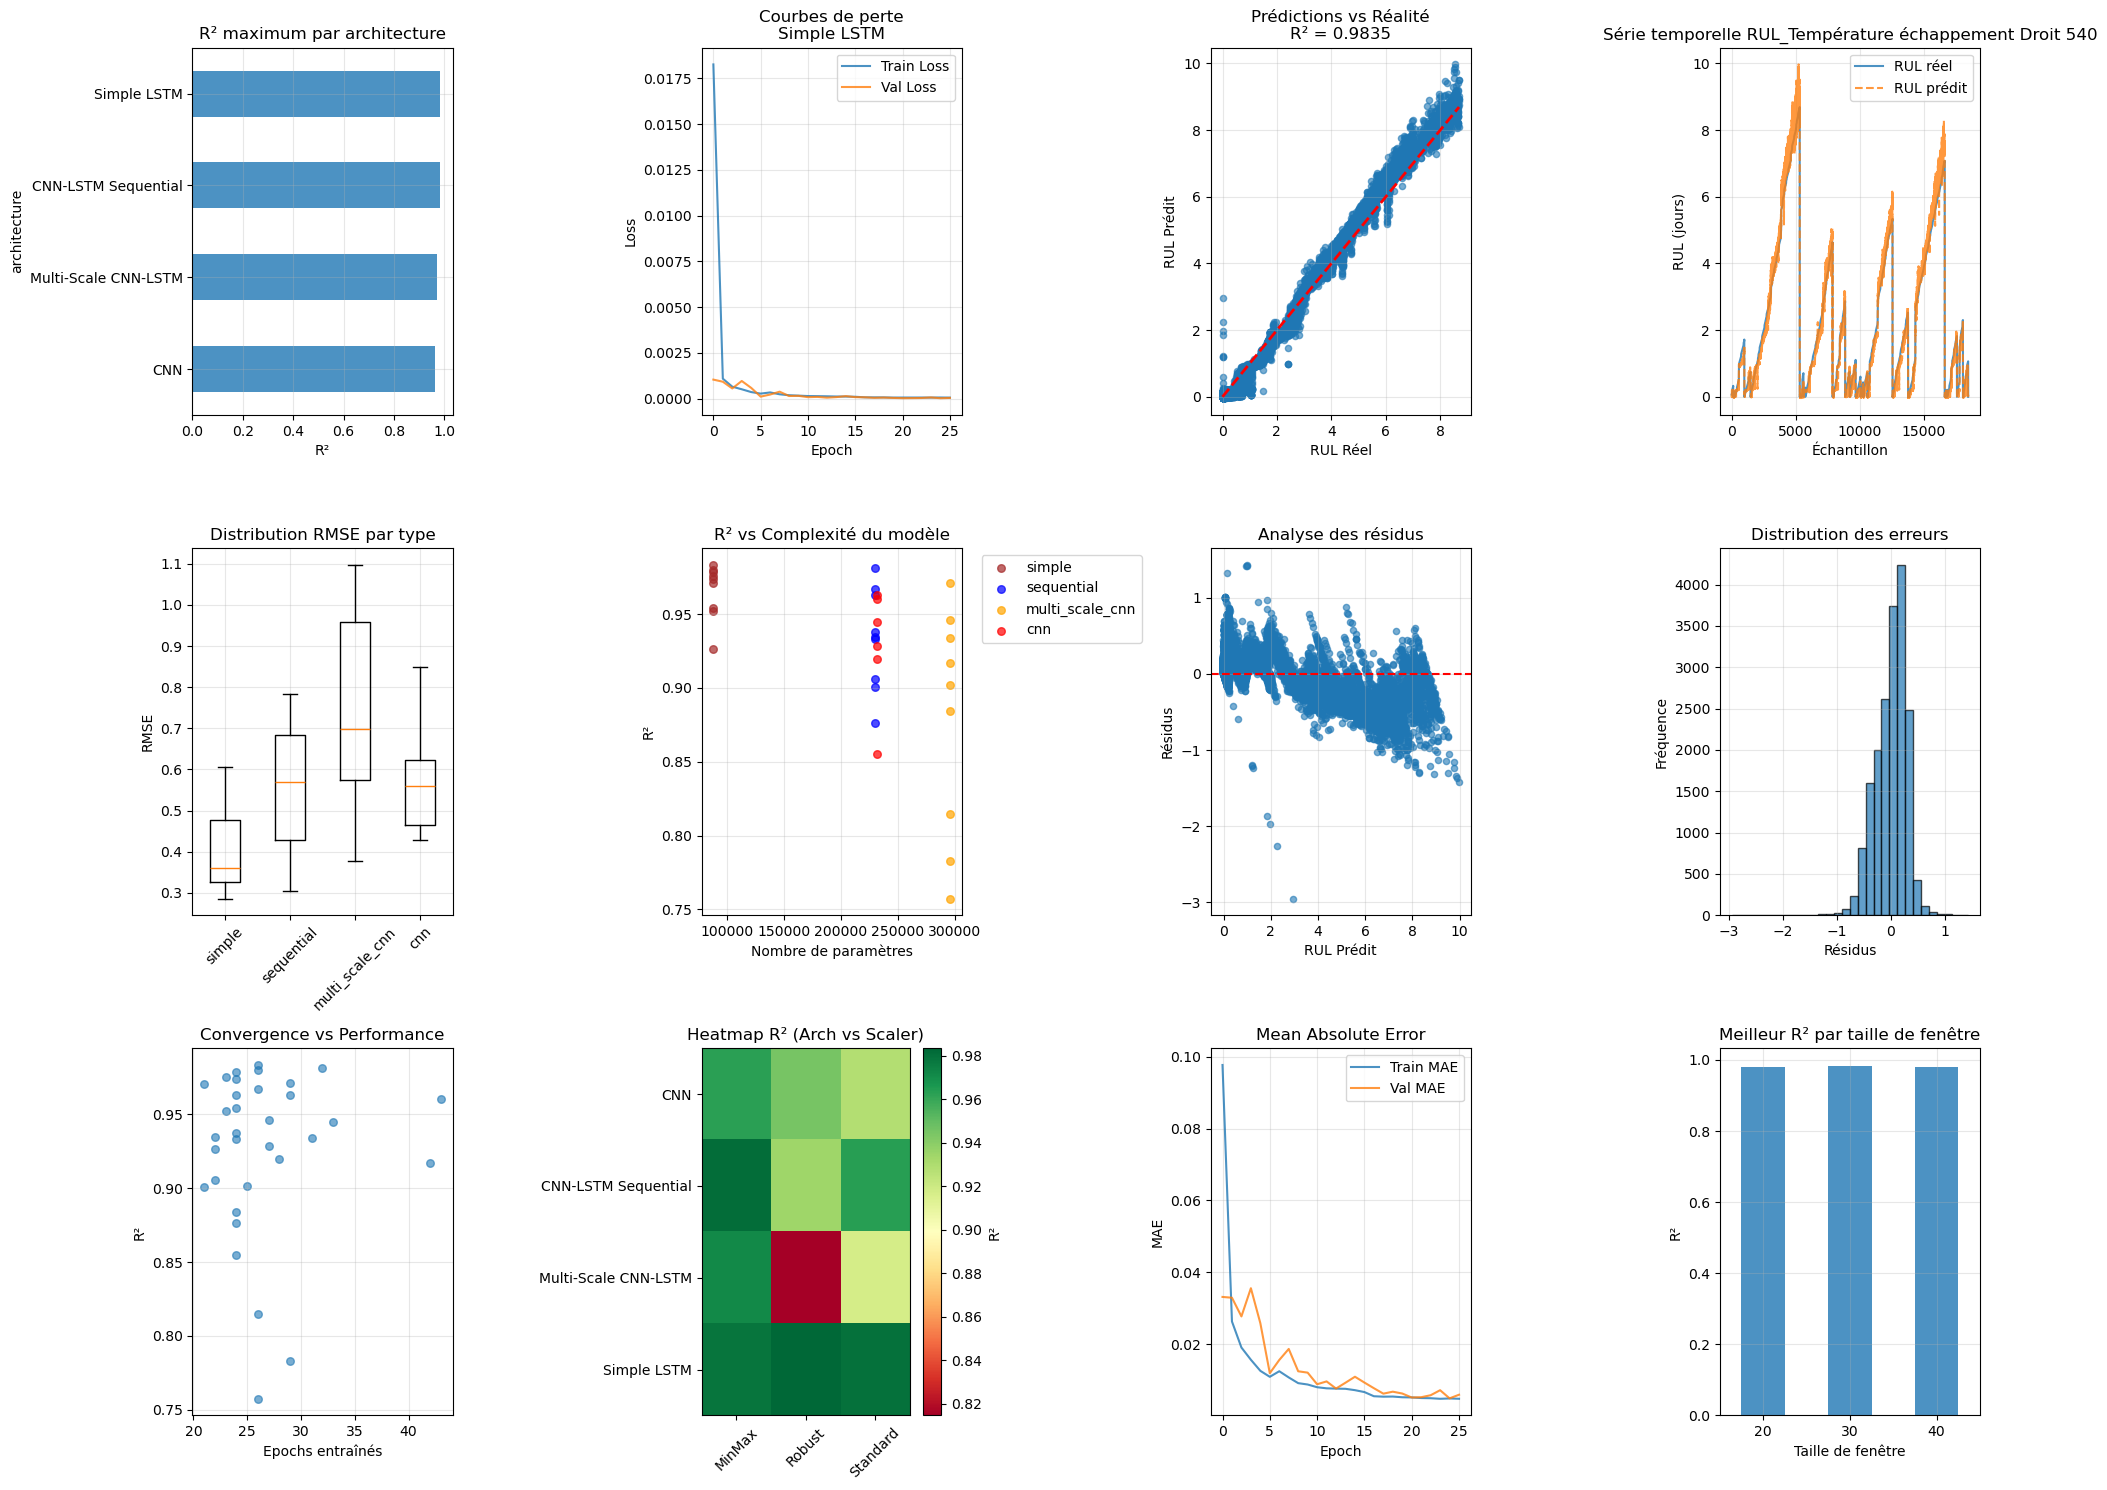


ANALYSE ET RECOMMANDATIONS CNN vs LSTM
Meilleur R² CNN/Hybride: 0.9814
Meilleur R² LSTM pur: 0.9835
Amélioration CNN vs LSTM: -0.21%


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Dense, Dropout, BatchNormalization, 
                                   Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
                                   Flatten, Input, concatenate, GlobalAveragePooling1D,
                                   SeparableConv1D, DepthwiseConv1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

def segment_signal(x, window_size):
    """Création de séquences avec chevauchement"""
    segments = []
    for i in range(len(x) - window_size + 1):
        segments.append(x[i:i+window_size])
    return np.array(segments)

def create_features(df, capteur_col):
    """Création de features engineered"""
    # Features statistiques sur fenêtre glissante
    window_sizes = [5, 10, 20]
    
    for w in window_sizes:
        df[f'{capteur_col}_mean_{w}'] = df[capteur_col].rolling(window=w, min_periods=1).mean()
        df[f'{capteur_col}_std_{w}'] = df[capteur_col].rolling(window=w, min_periods=1).std()
        df[f'{capteur_col}_min_{w}'] = df[capteur_col].rolling(window=w, min_periods=1).min()
        df[f'{capteur_col}_max_{w}'] = df[capteur_col].rolling(window=w, min_periods=1).max()
    
    # Tendance (différences)
    df[f'{capteur_col}_diff1'] = df[capteur_col].diff(1).fillna(0)
    df[f'{capteur_col}_diff2'] = df[capteur_col].diff(2).fillna(0)
    
    # Features temporelles
    if 'Heure' in df.columns:
        df['heure_sin'] = np.sin(2 * np.pi * df.index / len(df))
        df['heure_cos'] = np.cos(2 * np.pi * df.index / len(df))
    
    return df

def create_cnn_model(window_size, n_features):
    """Modèle CNN pur pour extraction de features"""
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, n_features)),
        BatchNormalization(),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(256, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    return model

def create_cnn_lstm_model(window_size, n_features, architecture='parallel'):
    """Modèles hybrides CNN-LSTM"""
    
    if architecture == 'sequential':
        # Architecture séquentielle : CNN puis LSTM
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, n_features)),
            BatchNormalization(),
            Conv1D(64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            Conv1D(128, kernel_size=3, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            
            # LSTM après CNN
            LSTM(128, return_sequences=True),
            Dropout(0.3),
            LSTM(64),
            Dropout(0.3),
            
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    
    elif architecture == 'parallel':
        # Architecture parallèle : CNN et LSTM séparés puis fusion
        input_layer = Input(shape=(window_size, n_features))
        
        # Branche CNN
        cnn_branch = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
        cnn_branch = BatchNormalization()(cnn_branch)
        cnn_branch = Conv1D(64, kernel_size=3, activation='relu')(cnn_branch)
        cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
        cnn_branch = Dropout(0.3)(cnn_branch)
        cnn_branch = Conv1D(128, kernel_size=3, activation='relu')(cnn_branch)
        cnn_branch = GlobalAveragePooling1D()(cnn_branch)
        cnn_branch = Dense(64, activation='relu')(cnn_branch)
        cnn_branch = Dropout(0.3)(cnn_branch)
        
        # Branche LSTM
        lstm_branch = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
        lstm_branch = Dropout(0.3)(lstm_branch)
        lstm_branch = Bidirectional(LSTM(64))(lstm_branch)
        lstm_branch = Dropout(0.3)(lstm_branch)
        lstm_branch = Dense(64, activation='relu')(lstm_branch)
        lstm_branch = Dropout(0.3)(lstm_branch)
        
        # Fusion des branches
        merged = concatenate([cnn_branch, lstm_branch])
        merged = Dense(128, activation='relu')(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(0.4)
        merged = Dense(64, activation='relu')(merged)
        merged = Dropout(0.3)(merged)
        output = Dense(1)(merged)
        
        model = Model(inputs=input_layer, outputs=output)
    
    elif architecture == 'multi_scale_cnn':
        # CNN multi-échelle avec différentes tailles de filtres
        input_layer = Input(shape=(window_size, n_features))
        
        # Différentes échelles de convolution
        conv1 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
        conv1 = BatchNormalization()(conv1)
        
        conv2 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_layer)
        conv2 = BatchNormalization()(conv2)
        
        conv3 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_layer)
        conv3 = BatchNormalization()(conv3)
        
        # Fusion des différentes échelles
        merged_conv = concatenate([conv1, conv2, conv3])
        merged_conv = MaxPooling1D(pool_size=2)(merged_conv)
        merged_conv = Dropout(0.3)(merged_conv)
        
        # Couches CNN supplémentaires
        x = Conv1D(128, kernel_size=3, activation='relu')(merged_conv)
        x = BatchNormalization()(x)
        x = Conv1D(128, kernel_size=3, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)
        
        # LSTM final
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = LSTM(64)(x)
        x = Dropout(0.3)(x)
        
        # Couches denses finales
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(1)(x)
        
        model = Model(inputs=input_layer, outputs=output)
    
    elif architecture == 'depthwise_separable':
        # CNN avec convolutions séparables (plus efficace)
        model = Sequential([
            SeparableConv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, n_features)),
            BatchNormalization(),
            SeparableConv1D(64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            SeparableConv1D(128, kernel_size=3, activation='relu'),
            BatchNormalization(),
            SeparableConv1D(128, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            # LSTM après CNN séparable
            LSTM(128, return_sequences=True),
            Dropout(0.3),
            LSTM(64),
            Dropout(0.3),
            
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    
    else:  # 'residual_cnn_lstm'
        # Architecture avec connexions résiduelles
        input_layer = Input(shape=(window_size, n_features))
        
        # Premier bloc CNN
        x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
        x = BatchNormalization()(x)
        residual1 = x
        
        x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual1])  # Connexion résiduelle
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)
        
        # Deuxième bloc CNN
        x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        residual2 = x
        
        x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual2])  # Connexion résiduelle
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)
        
        # LSTM
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dropout(0.3)(x)
        
        # Couches finales
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(1)(x)
        
        model = Model(inputs=input_layer, outputs=output)
    
    return model

def create_improved_model(window_size, n_features, architecture='bidirectional'):
    """Modèles LSTM classiques (de l'ancien code)"""
    if architecture == 'bidirectional':
        model = Sequential([
            Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, n_features)),
            Dropout(0.3),
            Bidirectional(LSTM(64)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    else:
        model = Sequential([
            LSTM(128, activation='tanh', input_shape=(window_size, n_features)),
            Dropout(0.4),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])
    
    return model

# Charger les données
file_path = "10_Sensor_Data_with_Rul2.xlsx"
sheet = "Sensor1HI"
df = pd.read_excel(file_path, sheet_name=sheet)
df = df.sort_values('Heure').reset_index(drop=True)

# Feature engineering
capteur_col = df.columns[2]
df = create_features(df, capteur_col)

# Sélection des features
feature_cols = [col for col in df.columns if col not in ['Heure', 'RUL_jour'] and not df[col].isna().all()]
X_features = df[feature_cols].fillna(method='ffill').fillna(method='bfill').values
y_target = df['RUL_jour'].values.reshape(-1, 1)

print(f"Nombre de features utilisées: {len(feature_cols)}")
print(f"Features: {feature_cols[:5]}...")

# Configuration des tests
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

# Architectures à tester (CNN + LSTM + modèles classiques)
architectures = {
    # Modèles CNN purs
    'CNN': 'cnn',
    
    # Modèles hybrides CNN-LSTM
    'CNN-LSTM Sequential': 'sequential',
    'CNN-LSTM Parallel': 'parallel',
    'Multi-Scale CNN-LSTM': 'multi_scale_cnn',
    
    # Modèles LSTM classiques pour comparaison
    'Simple LSTM': 'simple'
}

best_r2 = -np.inf
best_config = None
results = []

for scaler_name, scaler_X in scalers.items():
    print(f"\n=== Test avec {scaler_name}Scaler ===")
    
    # Normalisation
    X_scaled = scaler_X.fit_transform(X_features)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_target)
    
    # Test de différentes tailles de fenêtre
    for window_size in [20, 30, 40]:  # Fenêtres plus grandes pour CNN
        print(f"Fenêtre: {window_size}")
        
        # Création des séquences
        X_seq = segment_signal(X_scaled, window_size)
        y_seq = y_scaled[window_size-1:]
        
        # Reshape pour modèles
        X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], X_seq.shape[2]))
        
        # Split temporel
        split_idx = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
        y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
        
        # Test de toutes les architectures
        for arch_name, arch_type in architectures.items():
            try:
                print(f"  Architecture: {arch_name}")
                
                # Création du modèle selon le type
                if arch_type == 'cnn':
                    model = create_cnn_model(window_size, X_seq.shape[2])
                elif arch_type in ['sequential', 'parallel', 'multi_scale_cnn']:
                    model = create_cnn_lstm_model(window_size, X_seq.shape[2], arch_type)
                else:  # LSTM classiques
                    model = create_improved_model(window_size, X_seq.shape[2], arch_type)
                
                # Optimiseur adapté selon l'architecture
                if 'cnn' in arch_type.lower() or arch_type == 'cnn':
                    optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
                else:
                    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
                
                model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])
                
                # Callbacks
                early_stop = EarlyStopping(
                    monitor='val_loss',
                    patience=20,  # Plus de patience pour CNN
                    restore_best_weights=True,
                    min_delta=0.0005
                )
                
                reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.3,
                    patience=10,
                    min_lr=1e-7,
                    verbose=0
                )
                
                # Entraînement
                history = model.fit(
                    X_train, y_train,
                    epochs=200,  # Plus d'epochs pour CNN
                    batch_size=32,  # Batch size plus petit pour CNN
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, reduce_lr],
                    verbose=0
                )
                
                # Prédiction
                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                y_test_real = scaler_y.inverse_transform(y_test)
                
                # Métriques
                rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
                mae = mean_absolute_error(y_test_real, y_pred)
                r2 = r2_score(y_test_real, y_pred)
                
                result = {
                    'scaler': scaler_name,
                    'window': window_size,
                    'architecture': arch_name,
                    'arch_type': arch_type,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'epochs_trained': len(history.history['loss']),
                    'params': model.count_params()
                }
                results.append(result)
                
                print(f"    RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Params: {model.count_params()}")
                
                # Sauvegarder le meilleur modèle
                if r2 > best_r2:
                    best_r2 = r2
                    best_config = result.copy()
                    best_model = model
                    best_scaler_X = scaler_X
                    best_scaler_y = scaler_y
                    best_y_pred = y_pred
                    best_y_test = y_test_real
                    best_history = history
                
            except Exception as e:
                print(f"    Erreur avec {arch_name}: {str(e)}")
                continue

# Affichage des résultats
print("\n" + "="*80)
print("RÉSULTATS FINAUX - COMPARAISON CNN vs LSTM vs HYBRIDES")
print("="*80)

results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values('r2', ascending=False)
    
    print("\nTop 10 des configurations:")
    display_cols = ['architecture', 'scaler', 'window', 'rmse', 'mae', 'r2', 'params']
    print(results_df[display_cols].head(10).to_string(index=False))
    
    # Analyse par type d'architecture
    print(f"\n" + "="*50)
    print("ANALYSE PAR TYPE D'ARCHITECTURE")
    print("="*50)
    
    arch_analysis = results_df.groupby('arch_type').agg({
        'r2': ['mean', 'max', 'std'],
        'rmse': ['mean', 'min', 'std'],
        'params': 'mean'
    }).round(4)
    print(arch_analysis)
    
    print(f"\nMeilleure configuration globale:")
    print(f"Architecture: {best_config['architecture']}")
    print(f"Type: {best_config['arch_type']}")
    print(f"Scaler: {best_config['scaler']}")
    print(f"Fenêtre: {best_config['window']}")
    print(f"RMSE: {best_config['rmse']:.4f}")
    print(f"MAE: {best_config['mae']:.4f}")
    print(f"R²: {best_config['r2']:.4f}")
    print(f"Epochs entraînés: {best_config['epochs_trained']}")
    print(f"Nombre de paramètres: {best_config['params']:,}")

    # Visualisations complètes
    plt.figure(figsize=(20, 15))
    
    # 1. Comparaison des R² par architecture
    plt.subplot(3, 4, 1)
    arch_r2 = results_df.groupby('architecture')['r2'].max().sort_values(ascending=True)
    arch_r2.plot(kind='barh', alpha=0.8)
    plt.title('R² maximum par architecture')
    plt.xlabel('R²')
    plt.grid(True, alpha=0.3)
    
    # 2. Courbes de perte du meilleur modèle
    plt.subplot(3, 4, 2)
    plt.plot(best_history.history['loss'], label='Train Loss', alpha=0.8)
    plt.plot(best_history.history['val_loss'], label='Val Loss', alpha=0.8)
    plt.title(f'Courbes de perte\n{best_config["architecture"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Prédictions vs Réalité
    plt.subplot(3, 4, 3)
    plt.scatter(best_y_test, best_y_pred, alpha=0.6, s=20)
    plt.plot([best_y_test.min(), best_y_test.max()], 
             [best_y_test.min(), best_y_test.max()], 'r--', lw=2)
    plt.xlabel('RUL Réel')
    plt.ylabel('RUL Prédit')
    plt.title(f'Prédictions vs Réalité\nR² = {best_config["r2"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # 4. Série temporelle
    plt.subplot(3, 4, 4)
    indices = range(len(best_y_test))
    plt.plot(indices, best_y_test, label='RUL réel', alpha=0.8, linewidth=1.5)
    plt.plot(indices, best_y_pred, label='RUL prédit', alpha=0.8, linestyle='--', linewidth=1.5)
    plt.title('Série temporelle RUL_Température échappement Droit 540')
    plt.xlabel('Échantillon')
    plt.ylabel('RUL (jours)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Boxplot RMSE par type d'architecture
    plt.subplot(3, 4, 5)
    arch_types = results_df['arch_type'].unique()
    rmse_by_type = [results_df[results_df['arch_type'] == arch]['rmse'].values for arch in arch_types]
    plt.boxplot(rmse_by_type, labels=arch_types)
    plt.title('Distribution RMSE par type')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 6. Scatter R² vs Nombre de paramètres
    plt.subplot(3, 4, 6)
    colors = {'cnn': 'red', 'sequential': 'blue', 'parallel': 'purple', 
              'multi_scale_cnn': 'orange', 'simple': 'brown'}
    for arch_type in results_df['arch_type'].unique():
        mask = results_df['arch_type'] == arch_type
        plt.scatter(results_df[mask]['params'], results_df[mask]['r2'], 
                   label=arch_type, alpha=0.7, s=30,
                   color=colors.get(arch_type, 'black'))
    plt.xlabel('Nombre de paramètres')
    plt.ylabel('R²')
    plt.title('R² vs Complexité du modèle')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 7. Résidus
    plt.subplot(3, 4, 7)
    residuals = best_y_test.flatten() - best_y_pred.flatten()
    plt.scatter(best_y_pred, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('RUL Prédit')
    plt.ylabel('Résidus')
    plt.title('Analyse des résidus')
    plt.grid(True, alpha=0.3)
    
    # 8. Distribution des erreurs
    plt.subplot(3, 4, 8)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.title('Distribution des erreurs')
    plt.grid(True, alpha=0.3)
    
    # 9. Temps d'entraînement vs Performance
    plt.subplot(3, 4, 9)
    plt.scatter(results_df['epochs_trained'], results_df['r2'], alpha=0.6, s=30)
    plt.xlabel('Epochs entraînés')
    plt.ylabel('R²')
    plt.title('Convergence vs Performance')
    plt.grid(True, alpha=0.3)
    
    # 10. Heatmap des performances par scaler et architecture
    plt.subplot(3, 4, 10)
    pivot_table = results_df.pivot_table(values='r2', index='architecture', columns='scaler', aggfunc='max')
    plt.imshow(pivot_table.values, cmap='RdYlGn', aspect='auto')
    plt.colorbar(label='R²')
    plt.title('Heatmap R² (Arch vs Scaler)')
    plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45)
    plt.yticks(range(len(pivot_table.index)), pivot_table.index)
    
    # 11. MAE du meilleur modèle
    if 'mae' in best_history.history:
        plt.subplot(3, 4, 11)
        plt.plot(best_history.history['mae'], label='Train MAE', alpha=0.8)
        plt.plot(best_history.history['val_mae'], label='Val MAE', alpha=0.8)
        plt.title('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 12. Performance par taille de fenêtre
    plt.subplot(3, 4, 12)
    window_perf = results_df.groupby('window')['r2'].max()
    window_perf.plot(kind='bar', alpha=0.8)
    plt.title('Meilleur R² par taille de fenêtre')
    plt.xlabel('Taille de fenêtre')
    plt.ylabel('R²')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Recommandations spécifiques CNN
    print("\n" + "="*80)
    print("ANALYSE ET RECOMMANDATIONS CNN vs LSTM")
    print("="*80)
    
    cnn_results = results_df[results_df['arch_type'].str.contains('cnn|sequential|parallel')]
    lstm_results = results_df[results_df['arch_type'].str.contains('simple')]
    
    if not cnn_results.empty and not lstm_results.empty:
        best_cnn_r2 = cnn_results['r2'].max()
        best_lstm_r2 = lstm_results['r2'].max()
        
        print(f"Meilleur R² CNN/Hybride: {best_cnn_r2:.4f}")
        print(f"Meilleur R² LSTM pur: {best_lstm_r2:.4f}")
        print(f"Amélioration CNN vs LSTM: {((best_cnn_r2 - best_lstm_r2) / abs(best_lstm_r2) * 100):+.2f}%")
        
        if best_cnn_r2 > best_lstm_r2:
            print("\n✅ Les modèles CNN/Hybrides performent mieux!")
            print("• Les CNN capturent mieux les patterns locaux dans vos données")
            print("• L'architecture parallèle ou séquentielle CNN-LSTM est recommandée")
    else:
            print("\n⚠️  Les LSTM purs restent compétitifs")
    